In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import copy

import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
from src.data import load_dataset, load_relation


logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [3]:
import torch
import transformers
import baukit
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.models import ModelandTokenizer

MODEL_PATH = "state-spaces/mamba-2.8b-slimpj" # state-spaces/mamba-2.8b

mt = ModelandTokenizer(
    model_path=MODEL_PATH, 
    torch_dtype=torch.float32
)

2024-01-31 10:21:41 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2024-01-31 10:21:41 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/config.json HTTP/1.1" 200 0
2024-01-31 10:21:51 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /state-spaces/mamba-2.8b-slimpj/resolve/main/pytorch_model.bin HTTP/1.1" 302 0


/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-01-31 10:21:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /EleutherAI/gpt-neox-20b/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2024-01-31 10:21:54 src.models INFO     loaded model <state-spaces/mamba-2.8b-slimpj> | size: 10560.400 MB | dtype: torch.float32 | device: cuda


In [8]:
relation = load_relation(file = "../dataset/locality/place_in_city.json")

2024-01-31 10:24:11 src.data INFO     initialized relation -> "place in city" with 154 samples


In [10]:
from src.functional import filter_samples_by_model_knowledge
relation = filter_samples_by_model_knowledge(
    mt = mt,
    relation = relation,
)

2024-01-31 10:28:51 src.functional DEBUG    "place in city" | filtering with state-spaces/mamba-2.8b-slimpj


2024-01-31 10:28:52 src.functional DEBUG    sample.subject='Banff National Park' -> answer='Alberta' | predicted = ' Alberta'(0.786) ==> (✓)
2024-01-31 10:28:52 src.functional DEBUG    sample.subject='Colosseum' -> answer='Rome' | predicted = ' Rome'(0.859) ==> (✓)
2024-01-31 10:28:52 src.functional DEBUG    sample.subject='Sydney Opera House' -> answer='Sydney' | predicted = ' Sydney'(0.456) ==> (✓)
2024-01-31 10:28:52 src.functional DEBUG    sample.subject='Pyramids' -> answer='Giza' | predicted = ' G'(0.567) ==> (✓)
2024-01-31 10:28:52 src.functional DEBUG    sample.subject='Plaza de Mayo' -> answer='Buenos Aires' | predicted = ' Buenos'(0.757) ==> (✓)
2024-01-31 10:28:53 src.functional DEBUG    sample.subject='Krak des Chevaliers' -> answer='Homs' | predicted = ' H'(0.460) ==> (✓)
2024-01-31 10:28:53 src.functional DEBUG    sample.subject='Kremlin and Red Square' -> answer='Moscow' | predicted = ' Moscow'(0.898) ==> (✓)
2024-01-31 10:28:53 src.functional DEBUG    sample.subject='Su

In [81]:
from src.tracing import calculate_average_indirect_effects

prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

aie = calculate_average_indirect_effects(
    mt = mt,
    prompt = prompt_template,
    samples = relation.samples,
    corruption_strategy="alt_patch",
    n_trials=30,
    save_path="aie.json",
    mamba_block_hook = "mlp_after_silu"
)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [43:41<00:00, 87.38s/it] 


2024-01-31 16:03:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7efe7c46d180>


2024-01-31 16:03:53 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:03:53 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:03:53 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:03:53 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


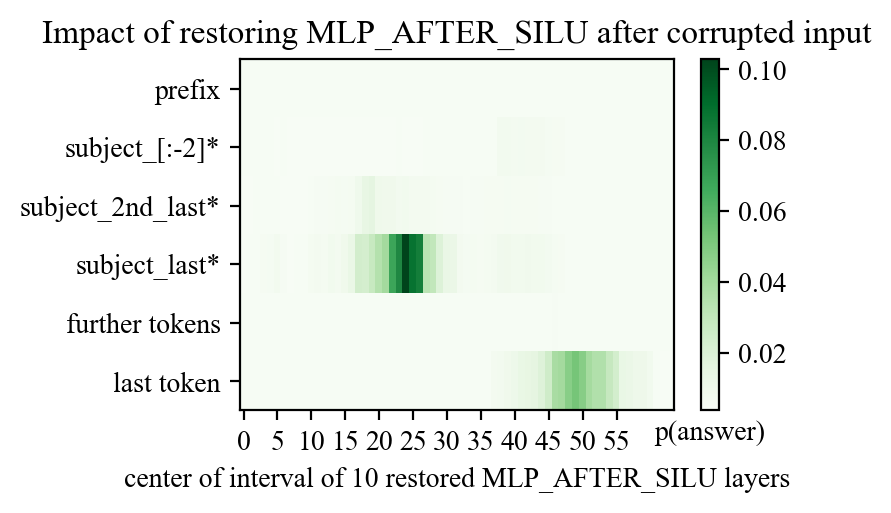

In [82]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(aie, modelname = mt.model_name.split("/")[-1])

In [83]:
from src.tracing import calculate_average_indirect_effects

prompt_template = mt.tokenizer.eos_token + " " + relation.prompt_templates[0]

aie = calculate_average_indirect_effects(
    mt = mt,
    prompt = prompt_template,
    samples = relation.samples,
    corruption_strategy="alt_patch",
    n_trials=30,
    save_path="aie.json",
    mamba_block_hook = "ssm_after_ssm"
)

100%|██████████| 30/30 [45:42<00:00, 91.40s/it] 


2024-01-31 16:53:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7efe8b7f5de0>
2024-01-31 16:53:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:53:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:53:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-01-31 16:53:31 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


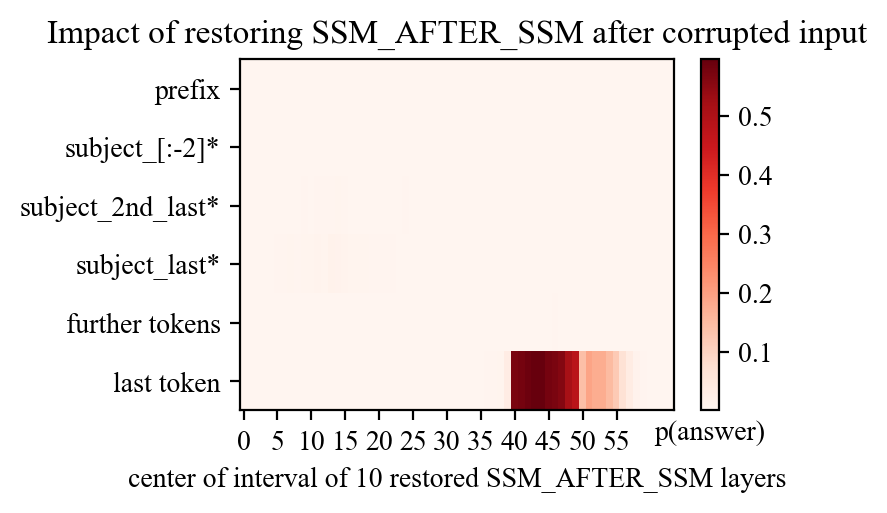

In [84]:
plot_trace_heatmap(aie, modelname = mt.model_name.split("/")[-1])